# Project 1 - Classification Using Baysian Decision Rule (Parametric Learning vs. Non-Parametric Learning)

<div align="center"> Md Inzamam Ul Haque </div>

## Objective
The objective of this project is, first of all, to learn how to implement the two types of learning algorithms based on Baysian decision theory, namely, parametric learning and non-parametric learning. In parametric learning, I will implement the three cases of discriminant functions assuming Gaussian pdf. In non-parametric learning, I will implement kNN. Equally important, the second objective is to get familiar with the design flow when applying machine learning algorithms to solve real-world problems. Some practical considerations include, for example:

- The selection of the right pdf model (or in that regard, modeless pdf) to characterize the data distribution in the training set
- The selection of the right ratio of prior probability
- The different ways to evaluate the performance of the learning algorithm, and
- How differently the same ML algorithm performs when applied to different datasets.

## Datasets
Two datasets will be used from Ripley's Pattern Recognition and Neural Networks, both are 2-category classification problems. The first is a synthetic dataset with 2 features where there are about equal number of samples in each category. The second is a dataset for diabetes in Pima Indians with 7 features where the number of diabetic patients is much less than that of the normal patients.

## Performance Metrics
Three metrics are used to evaluate the performance of the ML algorithms, including 1) overall classification accuracy, 2) classwise classification accuracy, and 3) run time.

Let's start by importing necessary packages. For data reading and cleaning purposes, I will use pandas. Pandas DataFrames are great ways to inspect the data in a tabular form and get summary statistics of the dataset. For data visualization, I will use matplotlib along with seaborn. For all other calculation purposes including training the ML models and getting predictions, I will use numpy. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import det, inv
import seaborn as sns
import time

%matplotlib inline 
sns.set_palette('Dark2')

Let's load the training samples of the synthetic dataset.

In [2]:
df = pd.read_csv('synth.csv')
df.head()

,xs,ys,yc
0,0.051008,0.160862,0
1,-0.748074,0.089040,0
2,-0.772934,0.263172,0
3,0.218374,0.127061,0
4,0.372683,0.496562,0


As we can see from the head of the DataFrame, there are two feature variables 'xs' and 'ys' and a target variable 'yc'. Let's get some more information from the training dataset. We will also change the type of target variable from integer to category. This will enable us to easily compute the covariance matrices later on. 

In [3]:
df['yc']=df['yc'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   xs      250 non-null    float64 
 1   ys      250 non-null    float64 
 2   yc      250 non-null    category
dtypes: category(1), float64(2)
memory usage: 4.4 KB


So, we have 250 training samples. Let's now visualize the training data as a scatter plot. Using Seaborn library along with matplotlib makes it really easy to draw colorful figures in a single line of code. 

Text(0.5, 1.0, 'Scatter plot of the training data for the Synthetic dataset')

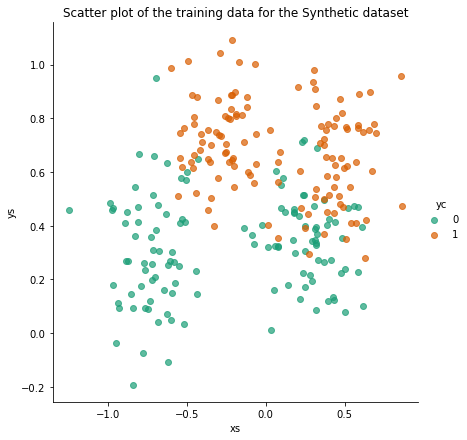

In [4]:
X_train = df[['xs','ys']].values
y_train = df['yc'].values

sns.FacetGrid(df, hue="yc", height=6).map(plt.scatter,"xs", "ys", alpha=0.7).add_legend()
plt.title('Scatter plot of the training data for the Synthetic dataset')

As we can see from this figure, class-0 and class-1 data points are labeled with different colors and can be clearly seen. Some transparency have been included in order to clearly see all the overlapping data points. From visual inspection, it is clear that a single-modal gaussian would not be a reasonable model for the pdf. A multivariate gaussian pdf would be necessary. Next, I will implement the three cases of discriminant analysis. But before doing that, let's import and clean the test data for synthetic dataset.

In [5]:
df_test = pd.read_csv('synth_test.csv')
df_test['yc']=df_test['yc'].astype('category')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   xs      1000 non-null   float64 
 1   ys      1000 non-null   float64 
 2   yc      1000 non-null   category
dtypes: category(1), float64(2)
memory usage: 16.8 KB


So, we have more testing samples than training samples, four times than the training data. Let's seperate the features and target variable.

In [6]:
X_test = df_test[['xs','ys']].values
y_test = df_test['yc'].values

print('Shape of the testing features:', X_test.shape)

Shape of the testing features: (1000, 2)


Now, it's time to implement our 1st discrimant case. I will define a seperate class for each case. Let's first implement case-1 and see it's performance on the testing dataset.
## Case-1
$\Sigma = \sigma^2I$ and $\Sigma_i = \Sigma$

Features are independent and equal spread along all dimensions and a linear decision boundary.<br>The objective function is derived from the discriminant function for normal density,

$$g_i(\vec{x}) = -\frac{1}{2}(\vec{x}-\vec{\mu_i})^T\Sigma_i^{-1}(\vec{x}-\vec{\mu_i})-\frac{1}{2}\ln\begin{vmatrix}\Sigma_i\end{vmatrix}+\ln{P{(w_i)}}$$

Substituting $\Sigma = \sigma^2I$ we get the objective function, which is the optimization method for case-1.

$$g_i(\vec{x}) = \frac{\mu_i^{T}}{\sigma^2}\vec{x}-\frac{\mu_i^{T}\mu_i}{2\sigma^2}+\ln{P{(w_i)}}$$
The equation for the decision boundary can be derived by setting the objective function for each class equal to one another.

$$\ln\frac{P{(w_0)}}{P{(w_1)}}-\frac{1}{2\sigma^2}(\vec{\mu_0}+\vec{\mu_1})^T(\vec{\mu_0}-\vec{\mu_1})+\frac{1}{\sigma^2}\vec{x}^T(\vec{\mu_0}-\vec{\mu_1})=0$$

Here, subscript 0 denotes to class-0 and subscript 1 denotes to class-1.

In [7]:
class case1:
    
    def __init__(self, sigma):
        self.sigma = sigma

    def calculate_boundary(self,X,mu0,mu1,pw0,pw1): 
        return ((np.log(pw0/pw1) - 1/(2*self.sigma[0][0])*(mu0 + mu1).T @(mu0 - mu1) +
                 1/self.sigma[0][0]*X.T @(mu0 - mu1)).flatten()[0])

    def score(self,X,mu,pw): 
        #Returns the discriminant score function for case 1
        return (np.log(pw) - 1/(2*self.sigma[0][0]) * (mu).T @(mu) + 1/self.sigma[0][0] * X.T @ (mu)).flatten()[0]   

    def predict_class(self,X,mu_list,pw_list): 
        #Returns the class for which the the discriminant score function is largest
        scores_list = []
        c = len(mu_list)

        for p in range(c):
            score = self.score(X.reshape(-1,1),mu_list[p].reshape(-1,1),pw_list[p]) 
            scores_list.append(score)

        return np.argmax(scores_list)

Before evaluating the performance of the model on the testing dataset, we have to train the model i.e. we have to first get the values of mean per class, $\mu_i$ and covariance matrix, $\Sigma$ from the training data. 

In [8]:
t0 = time.time() #start time

#Training phase

mu_list = np.split(df.groupby('yc').mean().values,2) # get the class-wise mean
sigma = df.cov().values #Covariance matrix
pw_list = df.iloc[:,2].value_counts().values / len(df) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict class labels from the testing data and find the accuracy of the model

c1 = case1(sigma) #getting a class object for case-1

#Testing phase
#claculating predictions
y_pred = np.array([c1.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test[:,0]), np.ravel(X_test[:,1]))]) 

t1 = time.time()

#calculate overall classification accuracy
acc = np.mean(y_pred == y_test) * 100

print(f'Overall accuracy of the case-1 model for the synthetic dataset is {acc} %, finished in {t1-t0} seconds')

Overall accuracy of the case-1 model for the synthetic dataset is 71.3 %, finished in 0.06440019607543945 seconds


In order to derive classwise accuracy, we can first divide the testing dataset per class and then repeat the same process for predicting labels.

In [9]:
df_test0 = df_test[df_test['yc']  == 0] # Testing dataset for class-0
df_test1 = df_test[df_test['yc']  == 1] # Testing dataset for class-1

X_test0 = df_test0[['xs','ys']].values  # Features for class-0
y_test0 = df_test0['yc'].values         # Target labels for class-0

X_test1 = df_test1[['xs','ys']].values  # Features for class-1
y_test1 = df_test1['yc'].values         # Target labels for class-1

#claculating predictions for class-0
y_pred0 = np.array([c1.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test0[:,0]), np.ravel(X_test0[:,1]))]) 

print(f'Class-0 accuracy of the case-1 model for the synthetic dataset is {np.mean(y_pred0 == y_test0)*100} %')

#claculating predictions for class-1
y_pred1 = np.array([c1.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test1[:,0]), np.ravel(X_test1[:,1]))]) 

print(f'Class-1 accuracy of the case-1 model for the synthetic dataset is {np.mean(y_pred1 == y_test1)*100} %')

Class-0 accuracy of the case-1 model for the synthetic dataset is 68.0 %
Class-1 accuracy of the case-1 model for the synthetic dataset is 74.6 %


Next, we can plot the decision boundary for case-1 parametric learning.

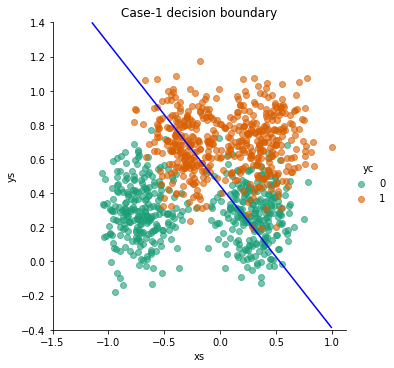

In [10]:
N = 200
X = np.linspace(-1.5, 1, N)  #got the boundaries for both axis from the scatterplot plotted before
Y = np.linspace(-0.4, 1.4, N) 
X, Y = np.meshgrid(X, Y)

#Initialize seaborn facetplot
fg = sns.FacetGrid(df_test, hue="yc", height=5).map(plt.scatter,"xs", "ys", alpha=0.6).add_legend()
ax = fg.ax #Retrieving the faceplot axes

boundary = np.array([c1.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                           mu_list[1].reshape(-1,1),pw_list[0],pw_list[1]) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y))])
    
#Reshaping the predicted class into the meshgrid shape
B = boundary.reshape(X.shape)

#Plot the boundary contour
ax.contour( X, Y, B , levels = [0] , colors = 'b')

# Addd axis and title
ax.set_xlabel('xs')
ax.set_ylabel('ys')
ax.set_title('Case-1 decision boundary')

plt.show()

## Case-2 
$\Sigma_i = \Sigma$\
Equal spread along all dimensions and a linear decision boundary.<br>
The objective function (optimazation method) for case-2 is:

$$g_i(\vec{x}) = -\frac{1}{2}(\vec{x}-\vec{\mu_i})^T\Sigma^{-1}(\vec{x}-\vec{\mu_i})+\ln{P({w_i})}$$

The decision boundary can be found by the following equation,

$$\ln\frac{P{(w_0)}}{P{(w_1)}}-\frac{1}{2}(\vec{\mu_0}+\vec{\mu_1})^T\Sigma^{-1}(\vec{\mu_0}-\vec{\mu_1})+\frac{1}{2}\vec{x}^T\Sigma^{-1}(\vec{\mu_0}-\vec{\mu_1})=0$$

Here, subscript 0 denotes to class-0 and subscript 1 denotes to class-1.

In [11]:
class case2:
    
    def __init__(self, sigma):
        self.sigma = sigma

    def calculate_boundary(self,X,mu0,mu1,pw0,pw1): 
        return (np.log(pw0/pw1) - 1/2*(mu0 + mu1).T @ inv(self.sigma) @ (mu0 - mu1) + 
                X.T @ inv(self.sigma) @ (mu0 - mu1)).flatten()[0]
    def score(self,X,mu,pw): 
        #Returns the discriminant score function for case 2
        return (np.log(pw) - 1/2*(mu).T@inv(self.sigma)@(mu) + X.T@inv(self.sigma)@(mu)).flatten()[0]      

    def predict_class(self,X,mu_list,pw_list): 
        #Returns the class for which the the discriminant score function is largest
        scores_list = []
        c = len(mu_list)

        for p in range(c):
            score = self.score(X.reshape(-1,1),mu_list[p].reshape(-1,1),pw_list[p]) 
            scores_list.append(score)

        return np.argmax(scores_list)

Let's now go over the training and testing phase and also calculate the run time.

In [12]:
t3 = time.time() #start time

#Training phase

mu_list = np.split(df.groupby('yc').mean().values,2) # get the class-wise mean
sigma1 = df.cov().values #Covariance matrix
pw_list = df.iloc[:,2].value_counts().values / len(df) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict class labels from the testing data and find the accuracy of the model

c2 = case2(sigma1) #getting a class object for case-2

#Testing phase
#claculating predictions
y_pred2 = np.array([c2.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test[:,0]), np.ravel(X_test[:,1]))]) 

t4 = time.time()

#calculate overall classification accuracy
acc = np.mean(y_pred2 == y_test) * 100

print(f'Overall accuracy of the case-2 model for the synthetic dataset is {acc} %, finished in {t4-t3} seconds')

Overall accuracy of the case-2 model for the synthetic dataset is 89.2 %, finished in 0.10247278213500977 seconds


Let's now calculate classwise accuracy for case-2.

In [13]:
#claculating predictions for class-0
y_pred20 = np.array([c2.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test0[:,0]), np.ravel(X_test0[:,1]))]) 

print(f'Class-0 accuracy of the case-2 model for the synthetic dataset is {np.mean(y_pred20 == y_test0)*100} %')

#claculating predictions for class-1
y_pred21 = np.array([c2.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test1[:,0]), np.ravel(X_test1[:,1]))]) 

print(f'Class-1 accuracy of the case-2 model for the synthetic dataset is {np.mean(y_pred21 == y_test1)*100} %')

Class-0 accuracy of the case-2 model for the synthetic dataset is 90.0 %
Class-1 accuracy of the case-2 model for the synthetic dataset is 88.4 %


Next, we can plot the decision boundary for case-2 by the 'calculate_boundary' function of the class 'case2'.

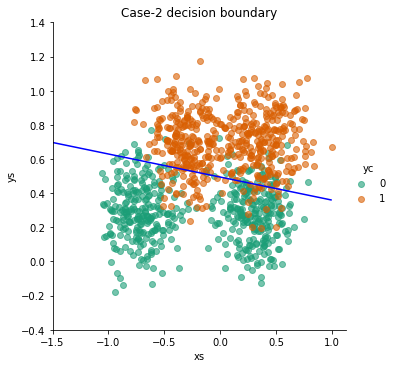

In [14]:
#Initialize seaborn facetplot
fg = sns.FacetGrid(df_test, hue="yc", height=5).map(plt.scatter,"xs", "ys", alpha=0.6).add_legend()
ax = fg.ax #Retrieving the faceplot axes

boundary = np.array([c2.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                           mu_list[1].reshape(-1,1),pw_list[0],pw_list[1]) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y))])
    
#Reshaping the predicted class into the meshgrid shape
B = boundary.reshape(X.shape)

#Plot the boundary contour
ax.contour( X, Y, B , levels = [0] , colors = 'b')

# Addd axis and title
ax.set_xlabel('xs')
ax.set_ylabel('ys')
ax.set_title('Case-2 decision boundary')

plt.show()

## Case-3
$\Sigma_i = arbitrary$

For this case, the covariance matrices are different for each class and it is a quadratic classifier. The objective function (optimization method) for this case is given by,

$$g_i(\vec{x}) = -\frac{1}{2}(\vec{x}-\vec{\mu_0})^T\Sigma_i^{-1}(\vec{x}-\vec{\mu_0})-\frac{1}{2}\ln\begin{vmatrix}\Sigma_i\end{vmatrix}+\ln{P{(w_i)}}$$

And the equation for the decision boundary can be derived as,

$$\ln\frac{\begin{vmatrix}\Sigma_0\end{vmatrix}}{\begin{vmatrix}\Sigma_1\end{vmatrix}}+(\vec{x}-\vec{\mu_0})^T\Sigma_0^{-1}(\vec{x}-\vec{\mu_0}) - (\vec{x}-\vec{\mu_1})^T\Sigma_1^{-1}(\vec{x}-\vec{\mu_1})=0$$

Here, subscript 0 denotes to class-0 and subscript 1 denotes to class-1.

In [15]:
class case3:
    
    def __init__(self):
        pass

    def calculate_boundary(self,X,mu0,mu1,sigma0,sigma1,pw0,pw1): 
        return (np.log(det(sigma0)/det(sigma1)) + (X-mu0).T @ inv(sigma0) @ (X-mu0)
           - (X-mu1).T @ inv(sigma1) @ (X-mu1)).flatten()[0]
    
    def score(self,X,mu,sigma,pw): 
        #Returns the discriminant score function for case 3
        return (np.log(pw) - 1/2*np.log(det(inv(sigma))) - 1/2*(X-mu).T@inv(sigma)@(X - mu)).flatten()[0]     

    def predict_class(self,X,mu_list,sigma_list,pw_list): 
        #Returns the class for which the the discriminant score function is largest
        scores_list = []
        c = len(mu_list)

        for p in range(c):
            score = self.score(X.reshape(-1,1),mu_list[p].reshape(-1,1),sigma_list[p],pw_list[p]) 
            scores_list.append(score)

        return np.argmax(scores_list)

Now, we can train the model check the accuracy of the case-3 model on the testing dataset.

In [16]:
t5 = time.time() #start time

#Training phase

mu_list = np.split(df.groupby('yc').mean().values,2) # get the class-wise mean
sigma_list = np.split(df.groupby('yc').cov().values, 2, axis=0) #Covariance matrix, different for each class
pw_list = df.iloc[:,2].value_counts().values / len(df) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict class labels from the testing data and find the accuracy of the model

c3 = case3() #getting a class object for case-3

#Testing phase
#claculating predictions
y_pred3 = np.array([c3.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test[:,0]), np.ravel(X_test[:,1]))]) 

t6 = time.time()

#calculate overall classification accuracy
acc = np.mean(y_pred3 == y_test) * 100

print(f'Overall accuracy of the case-3 model for the synthetic dataset is {acc} %, finished in {t6-t5} seconds')

Overall accuracy of the case-3 model for the synthetic dataset is 87.2 %, finished in 0.18126368522644043 seconds


Let's now calculate classwise accuracies for case-3

In [17]:
#claculating predictions for class-0
y_pred30 = np.array([c3.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test0[:,0]), np.ravel(X_test0[:,1]))]) 

print(f'Class-0 accuracy of the case-3 model for the synthetic dataset is {np.mean(y_pred30 == y_test0)*100} %')

#claculating predictions for class-1
y_pred31 = np.array([c3.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, sigma_list, pw_list) 
                   for xx, yy in zip(np.ravel(X_test1[:,0]), np.ravel(X_test1[:,1]))]) 

print(f'Class-1 accuracy of the case-3 model for the synthetic dataset is {np.mean(y_pred31 == y_test1)*100} %')

Class-0 accuracy of the case-3 model for the synthetic dataset is 96.39999999999999 %
Class-1 accuracy of the case-3 model for the synthetic dataset is 78.0 %


Let's now plot the quadratic decision boundary for case-3.

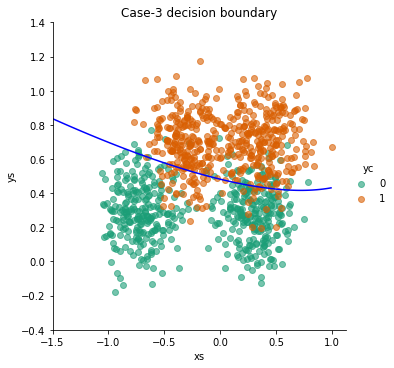

In [18]:
#Initialize seaborn facetplot
fg = sns.FacetGrid(df_test, hue="yc", height=5).map(plt.scatter,"xs", "ys", alpha=0.6).add_legend()
ax = fg.ax #Retrieving the faceplot axes

boundary = np.array([c3.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                           mu_list[1].reshape(-1,1), sigma_list[0] ,sigma_list[1], 
                                           pw_list[0],pw_list[1]) 
                     for xx, yy in zip(np.ravel(X), np.ravel(Y))])
    
#Reshaping the predicted class into the meshgrid shape
B = boundary.reshape(X.shape)

#Plot the boundary contour
ax.contour( X, Y, B , levels = [0] , colors = 'b')

# Addd axis and title
ax.set_xlabel('xs')
ax.set_ylabel('ys')
ax.set_title('Case-3 decision boundary')

plt.show()

## Prima Indians Dataset
It's time to repeat the same process for the Prima Indians dataset. We will observe the three performace metrics for each case of the discriminant function. But, first let's import the training and testing datasets and preprocess them.

In [19]:
df2_pre = pd.read_csv('prima.csv') #Training dataset
df2_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   npreg   200 non-null    int64  
 1   glu     200 non-null    int64  
 2   bp      200 non-null    int64  
 3   skin    200 non-null    int64  
 4   bmi     200 non-null    float64
 5   ped     200 non-null    float64
 6   age     200 non-null    int64  
 7   type    200 non-null    object 
dtypes: float64(2), int64(5), object(1)
memory usage: 12.6+ KB


As we can see, we have 200 training samples and seven features for this dataset. Let's see head of the data in a tabular form.

In [20]:
df2_pre.head()

,npreg,glu,bp,skin,bmi,ped,age,type
0,5,86,68,28,30.2,0.364,24,No
1,7,195,70,33,25.1,0.163,55,Yes
2,5,77,82,41,35.8,0.156,35,No
3,0,165,76,43,47.9,0.259,26,No
4,0,107,60,25,26.4,0.133,23,No


The target variable 'type' in this dataset consists of "Yes" and "No" values, meaning "with disease" and "without disease" respectively. For parameter estimation, we need the target variable to be in integer forms for the ease of calculation. So, let's convert the labels from "Yes" and "No" to "0" and "1" respectively.

In [21]:
df2_pre['type'] = df2_pre.iloc[:,7].replace({'Yes':0,'No':1}).copy()
df2_pre.head()

,npreg,glu,bp,skin,bmi,ped,age,type
0,5,86,68,28,30.2,0.364,24,1
1,7,195,70,33,25.1,0.163,55,0
2,5,77,82,41,35.8,0.156,35,1
3,0,165,76,43,47.9,0.259,26,1
4,0,107,60,25,26.4,0.133,23,1


Next, we need to normalize the feature variables so that all of them are on the same scale. We can achieve this by following code snippet.  

In [22]:
df2 = pd.DataFrame()   #Empty dataframe to store the normalized values

for i in df2_pre.columns[:len(df2_pre.columns)-1]: #looping from columns 0 to 6 i.e. all the features
    df2[i]  = (df2_pre[i] - df2_pre[i].mean()) / df2_pre[i].std()

df2['type'] = df2_pre['type']  #No change for the target variable

df2.head()

,npreg,glu,bp,skin,bmi,ped,age,type
0,0.424803,-1.199031,-0.283982,-0.103628,-0.344197,-0.314965,-0.738923,1
1,1.018933,2.243013,-0.109760,0.322826,-1.176142,-0.969209,2.085566,0
2,0.424803,-1.483237,0.935572,1.005152,0.569311,-0.991993,0.263315,1
3,-1.060522,1.295661,0.412906,1.175734,2.543142,-0.656734,-0.556698,1
4,-1.060522,-0.535885,-0.980870,-0.359501,-0.964078,-1.066857,-0.830035,1


Let's seperate feature and target variables from the dataset. It will be necessary for parameter estimation.

In [23]:
X2_data = df2.iloc[:,0:7]                     #Features for training data
y2_labels = df2.iloc[:,7]                     #Labels for training data

X2_data.shape              #Shpae of the training data

(200, 7)

Now, let's repeat the same steps for the testing dataset and make it ready for our classifiers.

In [24]:
df2_test = pd.read_csv('prima_test.csv')
df2_test['type'] = df2_test.iloc[:,7].replace({'Yes':0,'No':1})

#Normalize features of the testing dataset using the mean and standard deviation of training data
for i in df2_test.columns:
    if i != 'type':
        df2_test[i]  = (df2_test[i] - df2_pre[i].mean()) / df2_pre[i].std()  

df2_test.head()

,npreg,glu,bp,skin,bmi,ped,age,type
0,0.721868,0.758829,0.064462,0.493407,0.210433,0.541086,1.630004,0
1,-0.763457,-1.230610,-0.458204,-0.018338,-0.931452,-0.357279,-0.101135,1
2,-0.763457,-1.104296,-0.458204,-0.530082,-0.686763,-0.956189,-1.012260,1
3,-0.169327,-1.451659,-1.851980,0.237535,-0.213696,-0.692538,-0.556698,0
4,-0.466392,2.306170,-0.109760,1.346315,-0.295259,-0.985483,1.903341,0


For predicting classwise accuracy, we can divide this testing data per class and then feed them to our classifiers. 

In [25]:
df2_test_class0 = df2_test[df2_test['type']  == 0]   #DataFrame for class-0 (with disease)
df2_test_class1 = df2_test[df2_test['type']  == 1]   #DataFrame for class-1 (without disease)

X2_t_data = df2_test.iloc[:,0:7]                     #Features for test data
y2_t_labels = df2_test.iloc[:,7]                     #Labels for test data

X20_t_data = df2_test_class0.iloc[:,0:7]             #Features for class-0 test data
y20_t_labels = df2_test_class0.iloc[:,7]             #Labels for class-0 test data, all of them are 0 in this case

X21_t_data = df2_test_class1.iloc[:,0:7]             #Features for class-1 test data
y21_t_labels = df2_test_class1.iloc[:,7]             #Labels for class-1 test data, all of them are 1 in this case

X2_t_data.shape, X20_t_data.shape, X21_t_data.shape   #Shape for whole test data, class-0 test data, class-1 test data

((332, 7), (109, 7), (223, 7))

As we can see, our test data is imbalanced i.e. we have more than double samples for class-1 target labels than class-0. Is it the same case for training data as well? Let's see.

In [26]:
df2_class0 = df2[df2['type']  == 0]   #DataFrame for class-0 (with disease)
df2_class1 = df2[df2['type']  == 1]   #DataFrame for class-1 (without disease)

X20_data = df2_class0.iloc[:,0:7]             #Features for class-0 train data
y20_labels = df2_class0.iloc[:,7]             #Labels for class-0 train data, all of them are 0 in this case

X21_data = df2_class1.iloc[:,0:7]             #Features for class-1 train data
y21_labels = df2_class1.iloc[:,7]             #Labels for class-1 train data, all of them are 1 in this case

X2_data.shape, X20_data.shape, X21_data.shape   #Shape for whole train data, class-0 train data, class-1 train data

((200, 7), (68, 7), (132, 7))

Again, training dataset also contains nearly double class-1 data samples than class-0 data samples. We will see later on how this impacts on the performance of the learning algorithms. 

## Case-1
Let's test the performance of case-1 learning algorithm on the Prima Indians dataset.  

In [27]:
t7 = time.time() #start time

#Training phase

mu_list2 = np.split(df2.groupby('type').mean().values,2) #Classwise mean for 7 features
sigma_pr = X2_data.cov().values #Covariance matrix, equal for all the features
pw_list_pr = np.array([0.5,0.5]) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict labels from the testing data and find the accuracy of the model

c4 = case1(sigma_pr) #getting a class object for case-1

#Testing phase
#claculating predictions
y2_pred = np.array([c4.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                  for a,b,c,d,e,f,g in zip(np.ravel(X2_t_data.values[:,0]), np.ravel(X2_t_data.values[:,1]),
                                           np.ravel(X2_t_data.values[:,2]), np.ravel(X2_t_data.values[:,3]),
                                           np.ravel(X2_t_data.values[:,4]), np.ravel(X2_t_data.values[:,5]),
                                           np.ravel(X2_t_data.values[:,6]))])
t8 = time.time()

#calculate overall classification accuracy
acc = np.mean(y2_pred == y2_t_labels) * 100

print(f'Overall accuracy of the case-1 model for the Prima Indian dataset is {acc} %, finished in {t8-t7} seconds')

Overall accuracy of the case-1 model for the Prima Indian dataset is 74.09638554216868 %, finished in 0.06504487991333008 seconds


Let's calculate classwise accuracies for case-1

In [28]:
#claculating predictions for class-0
y20_pred = np.array([c4.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X20_t_data.values[:,0]), np.ravel(X20_t_data.values[:,1]),
                                              np.ravel(X20_t_data.values[:,2]), np.ravel(X20_t_data.values[:,3]),
                                              np.ravel(X20_t_data.values[:,4]), np.ravel(X20_t_data.values[:,5]),
                                              np.ravel(X20_t_data.values[:,6]))])

print(f'Class-0 accuracy of the case-1 model for the Prima dataset is {np.mean(y20_pred == y20_t_labels)*100} %')

#claculating predictions for class-1
y21_pred = np.array([c4.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X21_t_data.values[:,0]), np.ravel(X21_t_data.values[:,1]),
                                              np.ravel(X21_t_data.values[:,2]), np.ravel(X21_t_data.values[:,3]),
                                              np.ravel(X21_t_data.values[:,4]), np.ravel(X21_t_data.values[:,5]),
                                              np.ravel(X21_t_data.values[:,6]))])

print(f'Class-1 accuracy of the case-1 model for the Prima dataset is {np.mean(y21_pred == y21_t_labels)*100} %')

Class-0 accuracy of the case-1 model for the Prima dataset is 70.64220183486239 %
Class-1 accuracy of the case-1 model for the Prima dataset is 75.7847533632287 %


## Case-2
Now, let's test the performance of case-2 learning algorithm on the Prima Indians dataset.  

In [29]:
t9 = time.time() #start time

#Training phase

mu_list2 = np.split(df2.groupby('type').mean().values,2) #Classwise mean for 7 features
sigma_pr1 = X2_data.cov().values #Covariance matrix, equal for all the features
pw_list_pr = np.array([0.5,0.5]) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict labels from the testing data and find the accuracy of the model

c5 = case2(sigma_pr1) #getting a class object for case-2

#Testing phase
#claculating predictions
y2_pred2 = np.array([c5.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                  for a,b,c,d,e,f,g in zip(np.ravel(X2_t_data.values[:,0]), np.ravel(X2_t_data.values[:,1]),
                                           np.ravel(X2_t_data.values[:,2]), np.ravel(X2_t_data.values[:,3]),
                                           np.ravel(X2_t_data.values[:,4]), np.ravel(X2_t_data.values[:,5]),
                                           np.ravel(X2_t_data.values[:,6]))])
t10 = time.time()

#calculate overall classification accuracy
acc = np.mean(y2_pred2 == y2_t_labels) * 100

print(f'Overall accuracy of the case-2 model for the Prima Indian dataset is {acc} %, finished in {t10-t9} seconds')

Overall accuracy of the case-2 model for the Prima Indian dataset is 77.10843373493977 %, finished in 0.07254409790039062 seconds


In [30]:
#claculating predictions for class-0
y20_pred2 = np.array([c5.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X20_t_data.values[:,0]), np.ravel(X20_t_data.values[:,1]),
                                              np.ravel(X20_t_data.values[:,2]), np.ravel(X20_t_data.values[:,3]),
                                              np.ravel(X20_t_data.values[:,4]), np.ravel(X20_t_data.values[:,5]),
                                              np.ravel(X20_t_data.values[:,6]))])

print(f'Class-0 accuracy of the case-2 model for the Prima dataset is {np.mean(y20_pred2 == y20_t_labels)*100} %')

#claculating predictions for class-1
y21_pred2 = np.array([c5.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X21_t_data.values[:,0]), np.ravel(X21_t_data.values[:,1]),
                                              np.ravel(X21_t_data.values[:,2]), np.ravel(X21_t_data.values[:,3]),
                                              np.ravel(X21_t_data.values[:,4]), np.ravel(X21_t_data.values[:,5]),
                                              np.ravel(X21_t_data.values[:,6]))])

print(f'Class-1 accuracy of the case-2 model for the Prima dataset is {np.mean(y21_pred2 == y21_t_labels)*100} %')

Class-0 accuracy of the case-2 model for the Prima dataset is 74.31192660550458 %
Class-1 accuracy of the case-2 model for the Prima dataset is 78.47533632286996 %


## Case-3
Now, let's test the performance of case-3 learning algorithm on the Prima Indians dataset.  

In [31]:
t11 = time.time() #start time

#Training phase

mu_list2 = np.split(df2.groupby('type').mean().values,2) #Classwise mean for 7 features
sigma_list_pr = np.split(df2.groupby('type').cov().values, 2, axis=0) #different covariance matrix for each feature
pw_list_pr = np.array([0.5,0.5]) #equal prior probabilities for two classes, 0.5 each

#Time to use the case1 class to predict labels from the testing data and find the accuracy of the model

c6 = case3() #getting a class object for case-3

#Testing phase
#claculating predictions
y2_pred3 = np.array([c6.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, sigma_list_pr, pw_list_pr) 
                  for a,b,c,d,e,f,g in zip(np.ravel(X2_t_data.values[:,0]), np.ravel(X2_t_data.values[:,1]),
                                           np.ravel(X2_t_data.values[:,2]), np.ravel(X2_t_data.values[:,3]),
                                           np.ravel(X2_t_data.values[:,4]), np.ravel(X2_t_data.values[:,5]),
                                           np.ravel(X2_t_data.values[:,6]))])
t12 = time.time()

#calculate overall classification accuracy
acc = np.mean(y2_pred3 == y2_t_labels) * 100

print(f'Overall accuracy of the case-3 model for the Prima Indian dataset is {acc} %, finished in {t12-t11} seconds')

Overall accuracy of the case-3 model for the Prima Indian dataset is 55.42168674698795 %, finished in 0.07166814804077148 seconds


In [32]:
#claculating predictions for class-0
y20_pred3 = np.array([c6.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, sigma_list_pr, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X20_t_data.values[:,0]), np.ravel(X20_t_data.values[:,1]),
                                              np.ravel(X20_t_data.values[:,2]), np.ravel(X20_t_data.values[:,3]),
                                              np.ravel(X20_t_data.values[:,4]), np.ravel(X20_t_data.values[:,5]),
                                              np.ravel(X20_t_data.values[:,6]))])

print(f'Class-0 accuracy of the case-3 model for the Prima dataset is {np.mean(y20_pred3 == y20_t_labels)*100} %')

#claculating predictions for class-1
y21_pred3 = np.array([c6.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, sigma_list_pr, pw_list_pr) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X21_t_data.values[:,0]), np.ravel(X21_t_data.values[:,1]),
                                              np.ravel(X21_t_data.values[:,2]), np.ravel(X21_t_data.values[:,3]),
                                              np.ravel(X21_t_data.values[:,4]), np.ravel(X21_t_data.values[:,5]),
                                              np.ravel(X21_t_data.values[:,6]))])

print(f'Class-1 accuracy of the case-3 model for the Prima dataset is {np.mean(y21_pred3 == y21_t_labels)*100} %')

Class-0 accuracy of the case-3 model for the Prima dataset is 91.74311926605505 %
Class-1 accuracy of the case-3 model for the Prima dataset is 37.66816143497758 %


## Summary of Parametric Learning

We can summarize the performance metrics for the three learning algorithms of the discriminant function as below.
<br>
<br>
<div align="center"> Table 1. Performance Metrics for the Synthetic Dataset </div>

| Learning Algorithm | Overall Classification <br>Accuracy (%) | Class-0 Classification <br>Accuracy (%) | Class-1 Classification <br>Accuracy (%) | Run Time <br>(Seconds) |
|:-:|:-:|:-:|:-:|:-:|
| Case-1 | 71.3 | 68.0 | 74.6 | 0.1278 |
| Case-2 | 89.2 | 90.0 | 88.4 | 0.1549 |
| Case-3 | 87.2 | 96.4 | 78.0 | 0.1831 |

<br>
<div align="center"> Table 2. Performance Metrics for the Prima Indians Dataset </div>

| Learning Algorithm | Overall Classification <br>Accuracy (%) | Class-0 Classification <br>Accuracy (%) | Class-1 Classification <br>Accuracy (%) | Run Time <br>(Seconds) |
|:-:|:-:|:-:|:-:|:-:|
| Case-1 | 74.1 | 70.6 | 75.8 | 0.0387 |
| Case-2 | 77.1 | 74.3 | 78.5 | 0.0665 |
| Case-3 | 55.4 | 91.7 | 37.7 | 0.0802 |

<br>
As seen from Table 1, case-2 learning algorithm performs best on the synthetic dataset which is a linear discriminant function where we assumed equal covariance matrix for each class. The quadratic classifier, case-3, performs nearly as good as case-2 classifier. One thing to be noted here is that class-0 accuracy (96.4%) is much higher than class-1 accuracy (78%) for the quadratic classifier. This can be due to high variance as we need to estimate more parameters in case of case-3 learning algorithm. Also, overfitting to class-1 training labels can also be another reason. As expected, case-1 linear discrimant function performs well below than the other two functions as we assume all features are independent and have the same covariance matrix for this case. The run times also came out as expected, increasing from case-1 to case-3 gradually as more computation was needed for case-2 than case-1 and case-3 than case-2.

For the Prima Indians dataset, as seen from Table 2, again case-2, linear discrimant function performs best. The run times are again consistent with expectations. But the quadratic classifier, case-3 performs really poor on this dataset, specially in predicting class-1 labels. We have inspected previously that there was an imbalance of data points for the two classes in both the training and testing datasets. This can be a reason for this poor performance of the quadratic discriminant function. Also, the higher the dimension of the data set (the more predictors in a data set) the more parameters we have to estimate. This can lead to a high variance and so we have to be careful when using Quadratic classifier.

In conclusion, Linear function is less flexible than Quadratic function because we have to estimate less parameters. This can be good when we have only a few observations in our training data set so we lower the variance, which is the case for our datasets in this project. So, what is comes down to is the bias-variance trade-off. Therefore, it is crucial to test the underlying assumptions of all the cases on the dataset and then use both linear and quadratic methods to decide which one is more appropriate.

Using only the synthetic dataset, let's illustrate the three decision boundaries from the three cases of parametric learning algorithms on the same figure as the scatter plot of the testing dataset.

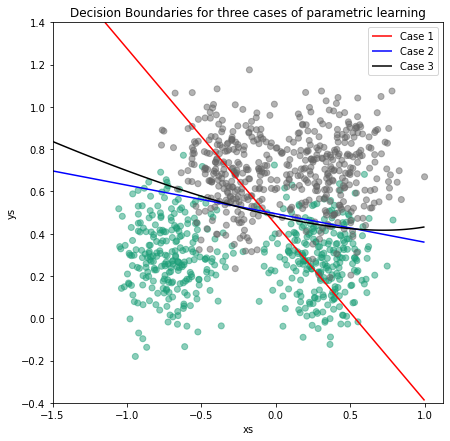

In [33]:
aa = np.array([c1.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                     mu_list[1].reshape(-1,1), pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

bb = np.array([c2.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                     mu_list[1].reshape(-1,1), pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

cc = np.array([c3.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1), 
                                     mu_list[1].reshape(-1,1), sigma_list[0] ,sigma_list[1], pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

A = aa.reshape(X.shape)
B = bb.reshape(X.shape)
C = cc.reshape(X.shape)

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(df_test["xs"], df_test["ys"], c=df_test['yc'], cmap='Dark2', alpha=0.5)

cntr1 = ax.contour( X, Y, A , levels = [0] , colors = 'r')
cntr2 = ax.contour( X, Y, B , levels = [0] , colors = 'b')
cntr3 = ax.contour( X, Y, C , levels = [0] , colors = 'black')

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()

ax.legend([h1[0], h2[0], h3[0]], ['Case 1', 'Case 2', 'Case 3'])

# Addd axis and title
ax.set_xlabel('xs')
ax.set_ylabel('ys')
ax.set_title('Decision Boundaries for three cases of parametric learning')

plt.show()

This scatter plot helps to better understand the result we got. Clearly, case-1 function performs poor as seen from the Table-1. Case-2 decision boundary seems to be the most reasonable one which is actually true as seen from the summary table. From visual inspection, it seems that the case-3 function has a decision boundary biased for class-0. It looks like that it better recognizes class-0 labels, which is true as seen from the Table-1. 

So far, for all the cases, we have assumed equal prior probability of 0.5. Let's vary the ratio of prior probabilities and see the effect on performance. We will only use class-0 accuracy of case-2 parametric function (the best performer) for this purpose. 

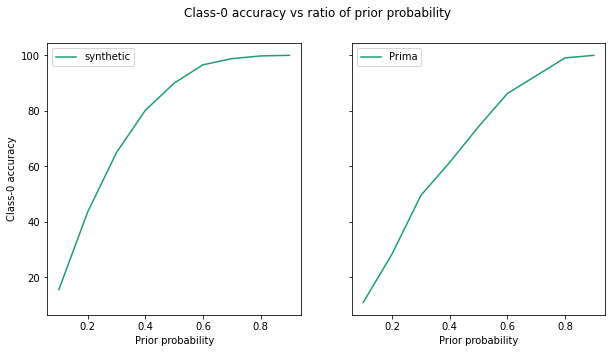

In [34]:
#Define different combinations of prior probabilities starting from 0.1 to 0.9

prior = [[0.1,0.9],[0.2,0.8],[0.3,0.7],[0.4,0.6],[0.5,0.5],[0.6,0.4],[0.7,0.3],[0.8,0.2],[0.9,0.1]]
y_list_sy = [] #empty list to hold values for predictions for different prior probability combinations - synthetic
y_list_pr = [] #empty list to hold values for predictions for different prior probability combinations - Prima

#Synthetic Dataset
for i in prior:
    y_pred_sy = np.array([c2.predict_class(np.array([xx,yy]).reshape(-1,1), mu_list, i) 
                   for xx, yy in zip(np.ravel(X_test0[:,0]), np.ravel(X_test0[:,1]))]) 
    
    y_list_sy.append(np.mean(y_pred_sy == y_test0)*100)

#Prima Dataset
for j in prior:
    y_pred_pr = np.array([c5.predict_class(np.array([a,b,c,d,e,f,g]).reshape(-1,1), mu_list2, j) 
                     for a,b,c,d,e,f,g in zip(np.ravel(X20_t_data.values[:,0]), np.ravel(X20_t_data.values[:,1]),
                                              np.ravel(X20_t_data.values[:,2]), np.ravel(X20_t_data.values[:,3]),
                                              np.ravel(X20_t_data.values[:,4]), np.ravel(X20_t_data.values[:,5]),
                                              np.ravel(X20_t_data.values[:,6]))])

    y_list_pr.append(np.mean(y_pred_pr == y20_t_labels)*100)

p = np.array(prior)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = [10,5])
fig.suptitle('Class-0 accuracy vs ratio of prior probability')

ax1.plot(p[:,0],y_list_sy, label='synthetic')
ax1.set_xlabel('Prior probability')
ax1.set_ylabel('Class-0 accuracy')

ax2.plot(p[:,0],y_list_pr,label='Prima')
ax2.set_xlabel('Prior probability')

for ax in [ax1,ax2]:
    ax.legend()

As we can see, class-0 accuracy increases for both datasets as the prior probability for class-0 increases. That is why for both datasets, the curve is similar. We can generalize this into an information which is, as the prior probability for a particular class increases, accuracy of the model for that specific class also increases. This is true for all the cases of parametric learning. I have checked this with other cases too. 

# Nonparametric Learning - k Nearest Neighbor

So far, we have seen three cases of parametric learning. Using the same two datasets, we will now implement nonparametric learning algorithm. kNN is a nonparametric learning algorithm as it doesn't need to estimate any  parameter from the training data. Let's first build a class for kNN. Then we can implement that on our datasets and see the performance compared to parametric learning.  

In [35]:
class kNearestNeighbors:
    
    def __init__(self, features, labels, k):
        self.features = np.array(features)
        self.labels = np.array(labels)
        self.k = k
        
    def _neighbor(self, test_data):
        
        # Calculate distance of a test data point from all other samples, we use euclidean distance
        difference = (self.features - test_data) ** 2
        euclidean_distances = np.sqrt(difference.sum(axis=1))
        
        # We need to sort index of distances and then keep only the first 'K' ones
        sorted_distances = euclidean_distances.argsort()[:self.k]
                
        # Determine the class of a testing sample
        classes = {}
        for i in sorted_distances:
            label = self.labels[i]
            classes[label] = classes.get(label, 0) + 1
            
        # Sort classes by value in decending order
        sorted_class = sorted(classes.items(),key= lambda x: (x[1], x[0]),reverse=True)
        
        # Return the one with majority vote
        return sorted_class[0][0]
    
    def predict(self, test_label):
        predictions = []
        # Iterate over all the samples, predict the class labels and store the results in a list
        for i in test_label:
            predictions.append(self._neighbor(i))
        
        return np.array(predictions)
    
    def accuracy(self, actual, preds):
        total = len(actual)
        
        # Calculate the number of wrong predictions
        wrong = sum((actual - preds) != 0)

        return ((total - wrong) / total)*100  

Let's prepare our training and testing data for both datasets so than we can use them in our knn class.

In [36]:
y_train = y_train.astype('int64')               # Converting training labels to integers from categories - synth data
y_test = y_test.astype('int64')                 # Converting testing labels to integers from categories - synth data

y2_labels = np.array(y2_labels)            # training labels for Prima dataset
y2_t_labels = np.array(y2_t_labels)        # testing labels for Prima dataset

X2_data = np.array(X2_data)               # Training data for Prima dataset
X2_t_data = np.array(X2_t_data)           # Testing data for Prima dataset

Let's now calculate overall accuracy of the knn classifier for the Synthetic dataset for k=3

In [37]:
clf = kNearestNeighbors(X_train, y_train, 3)
t13 = time.time()
preds1 = clf.predict(X_test)
acc1 = clf.accuracy(y_test, preds1)
t14 = time.time()
print(f'kNN overall accuracy for the Synthetic dataset with k=3 is {acc1}%, finished in {t14-t13} seconds')

kNN overall accuracy for the Synthetic dataset with k=3 is 86.6%, finished in 0.049713850021362305 seconds


But, how do we know which k to choose? We can plot accuracies of the model for different values of k. The range of k should be from 1 to $\sqrt{n}$ where $n$ is the number of training samples. Before doing that, let's see if our kNN classifier works for the Prima Indians dataset.

In [38]:
clf2 = kNearestNeighbors(X2_data, y2_labels, 3)
t15 = time.time()
preds2 = clf2.predict(X2_t_data)
acc2 = clf2.accuracy(y2_t_labels, preds2)
t16 = time.time()
print(f'kNN overall accuracy for the Prima Indian dataset with k=3 is {acc2}%, finished in {t16-t15} seconds')

kNN overall accuracy for the Prima Indian dataset with k=3 is 74.09638554216868%, finished in 0.01589202880859375 seconds


Great, It works! Let's find the optimal k now and plot accuracy vs k for both datasets.

In [39]:
# Loop through k to sqrt(n) and store the accuracies
#Synthetic
accuracies = []

for k in range(1,17):
    clf = kNearestNeighbors(X_train, y_train, k)
    preds = clf.predict(X_test)
    acc = clf.accuracy(y_test, preds)
    accuracies.append((k,acc))

In [40]:
# Loop through k to sqrt(n) and store the accuracies
#Prima Indians

accuracies_pr = []

for k in range(1,16):
    clf = kNearestNeighbors(X2_data, y2_labels, k)
    preds = clf.predict(X2_t_data)
    acc = clf.accuracy(y2_t_labels, preds)
    accuracies_pr.append((k,acc))

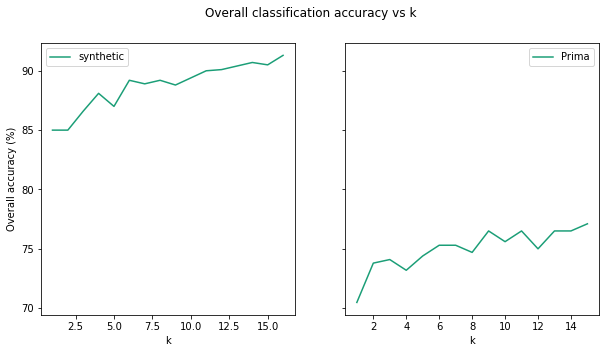

In [41]:
#Plot accuracy vs k

accuracies = np.array(accuracies)
accuracies_pr = np.array(accuracies_pr)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = [10,5])
fig.suptitle('Overall classification accuracy vs k')

ax1.plot(accuracies[:,0],accuracies[:,1], label='synthetic')
ax1.set_xlabel('k')
ax1.set_ylabel('Overall accuracy (%)')

ax2.plot(accuracies_pr[:,0],accuracies_pr[:,1],label='Prima')
ax2.set_xlabel('k')

for ax in [ax1,ax2]:
    ax.legend()

As we can see from this plot, accuracies for both datasets are increasing with the value of k increasing. If we opt for higher values of k, maybe the accuracy will be higher, but a high value of k can overfit the model to the data. To get the best overall accuracy, I will choose k=16 for the synthetic dataset and k=15 for the Prima Indians dataset. Let's see the accuracy with these values of k.

In [42]:
clf = kNearestNeighbors(X_train, y_train, 16)
t13 = time.time()
preds1 = clf.predict(X_test)
acc1 = clf.accuracy(y_test, preds1)
t14 = time.time()
print(f'kNN overall accuracy for the Synthetic dataset with k=16 is {acc1}%, finished in {t14-t13} seconds')

kNN overall accuracy for the Synthetic dataset with k=16 is 91.3%, finished in 0.044677734375 seconds


In [43]:
clf2 = kNearestNeighbors(X2_data, y2_labels, 15)
t15 = time.time()
preds2 = clf2.predict(X2_t_data)
acc2 = clf2.accuracy(y2_t_labels, preds2)
t16 = time.time()
print(f'kNN overall accuracy for the Prima Indian dataset with k=15 is {acc2}%, finished in {t16-t15} seconds')

kNN overall accuracy for the Prima Indian dataset with k=15 is 77.10843373493977%, finished in 0.01629805564880371 seconds


We can get the confusion matrix for the synthetic dataset as follows.

In [44]:
actual = pd.Series(y_test, name='Actual')
predicted = pd.Series(preds1, name='Predicted')

confusion_matrix = pd.crosstab(actual, predicted)
confusion_matrix

Predicted,0,1
Actual,,
0,458,42
1,45,455


Let's compute the class-0 and class-1 accuracies based on the confusion matrix.

In [45]:
c0_acc = (confusion_matrix[0][0]/(confusion_matrix[0][0]+confusion_matrix[1][0]))*100
print(f'Class-0 accuracy for the synthetic dataset with k = 16 is {c0_acc}%')

c1_acc = (confusion_matrix[1][1]/(confusion_matrix[0][1]+confusion_matrix[1][1]))*100
print(f'Class-1 accuracy for the synthetic dataset with k = 16 is {c1_acc}%')

Class-0 accuracy for the synthetic dataset with k = 16 is 91.60000000000001%
Class-1 accuracy for the synthetic dataset with k = 16 is 91.0%


And for the Prima dataset:

In [46]:
actual2 = pd.Series(y2_t_labels, name='Actual')
predicted2 = pd.Series(preds2, name='Predicted')

confusion_matrix2 = pd.crosstab(actual2, predicted2)
confusion_matrix2

Predicted,0,1
Actual,,
0,56,53
1,23,200


In [47]:
c0_acc2 = (confusion_matrix2[0][0]/(confusion_matrix2[0][0]+confusion_matrix2[1][0]))*100
print(f'Class-0 accuracy for the Prima dataset with k = 15 is {c0_acc2}%')

c1_acc2 = (confusion_matrix2[1][1]/(confusion_matrix2[0][1]+confusion_matrix2[1][1]))*100
print(f'Class-1 accuracy for the Prima dataset with k = 15 is {c1_acc2}%')

Class-0 accuracy for the Prima dataset with k = 15 is 51.37614678899083%
Class-1 accuracy for the Prima dataset with k = 15 is 89.68609865470853%


# Summary of Nonparametric Learning

As before, let's summarize the performace of kNN along with the three cases of parametric learning for both datasets.
<br>
<br>
<div align="center"> Table 1. Performance Metrics for the Synthetic Dataset </div>

| Learning Algorithm | Overall Classification <br>Accuracy (%) | Class-0 Classification <br>Accuracy (%) | Class-1 Classification <br>Accuracy (%) | Run Time <br>(Seconds) |
|:-:|:-:|:-:|:-:|:-:|
| Case-1 | 71.3 | 68.0 | 74.6 | 0.1278 |
| Case-2 | 89.2 | 90.0 | 88.4 | 0.1549 |
| Case-3 | 87.2 | 96.4 | 78.0 | 0.1831 |
| kNN | 91.3 | 91.6 | 91.0 | 0.0527 |

<br>
<div align="center"> Table 2. Performance Metrics for the Prima Indians Dataset </div>

| Learning Algorithm | Overall Classification <br>Accuracy (%) | Class-0 Classification <br>Accuracy (%) | Class-1 Classification <br>Accuracy (%) | Run Time <br>(Seconds) |
|:-:|:-:|:-:|:-:|:-:|
| Case-1 | 74.1 | 70.6 | 75.8 | 0.0387 |
| Case-2 | 77.1 | 74.3 | 78.5 | 0.0665 |
| Case-3 | 55.4 | 91.7 | 37.7 | 0.0802 |
| kNN | 77.1 | 51.4 | 89.7 | 0.0254 |

<br>
We can say that for both datasets, kNN performed better than three cases of parametric learning. The run time is less for kNN than parametric learning cases. Although, for large datasets this would change as kNN is more computationally expensive. Based on the performance of the parametric and nonparametric learning on this two datasets, let's discuss some pros and cons for each type of learning.

## Pros and cons of parametric learning
### Pros
- These learning algorithms are simple enough to understand and implement easily. 
- Training process is easy. Just need to learn the coefficients for the score function
- Learns fast from the data. 
- Works well with small datasets even if the fit to data is not that good.

### Cons
- Function specific learning meaning less flexibility and high constraint.
- Most of the time fits poorly to the data because of being linear or quadratic in nature.
- Assumes a lot of things and those need to be met in order to implement the algorithm.
- Feature variables should be independent, so these algorithms are more suited for simpler problems.

## Pros and cons of nonparametric learning
### Pros
- Not dependent on any particular function. So, they can fit better to any underlying distribution. Independent of the training data.
- Usually achieves higer performance than parametric learning as seen from this project.
- Assumptions are absent, even if they are present they are weak.

### Cons
- Usually requires more training data to map the underlying function. That is why in this case, kNN achieved less performance with the Prima Indians dataset.
- Slower to train and computationally more expensive. For kNN, for each testing data the algorithm goes through the whole training dataset to compute distances.
- More chances to overfit to the training data as it happened with kNN for the Prima Indians dataset. 

Let's now see if we can plot the decision boundary along with decision regions for kNN on the synthetic dataset.

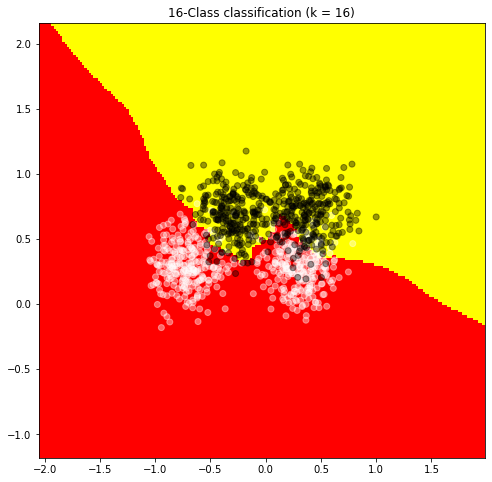

In [48]:
#Get boundary levels
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=[8,8])
plt.pcolormesh(xx, yy, Z, cmap='autumn')

# Plot also the training points
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='binary', alpha=0.4)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("16-Class classification (k = 16)")
plt.show()

Here, I did not write a function to plot the boundary as we don't have one for kNN. So, first I defined our X-axis and Y-axis values based on the testing dataset. Then for each pair of (X,Y) value I calculated the prediction using our kNN classifier and color coded them. That's how wI got this beautiful looking figure of decision boundary. I have used k=16 as this gives the highest accuracy. 

We can plot all the decision boundaries for the four learning algorithms we have tried so far using contour plots.

<ipython-input-49-755eb4bd85bd>:27: UserWarning: No contour levels were found within the data range.
  cntr4 = ax.contour( X, Y, Z , levels = [0] , colors = 'r')


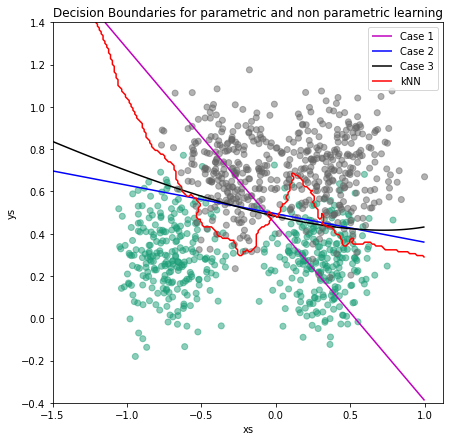

In [49]:
aa = np.array([c1.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                     mu_list[1].reshape(-1,1), pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

bb = np.array([c2.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1),
                                     mu_list[1].reshape(-1,1), pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

cc = np.array([c3.calculate_boundary(np.array([xx,yy]).reshape(-1,1),mu_list[0].reshape(-1,1), 
                                     mu_list[1].reshape(-1,1), sigma_list[0] ,sigma_list[1], pw_list[0],pw_list[1]) 
               for xx, yy in zip(np.ravel(X), np.ravel(Y))])

Z = clf.predict(np.c_[np.ravel(X), np.ravel(Y)])

A = aa.reshape(X.shape)
B = bb.reshape(X.shape)
C = cc.reshape(X.shape)
Z = Z.reshape(X.shape)

fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(df_test["xs"], df_test["ys"], c=df_test['yc'], cmap='Dark2', alpha=0.5)

cntr1 = ax.contour( X, Y, A , levels = [0] , colors = 'm')
cntr2 = ax.contour( X, Y, B , levels = [0] , colors = 'b')
cntr3 = ax.contour( X, Y, C , levels = [0] , colors = 'black')
cntr4 = ax.contour( X, Y, Z , levels = [0] , colors = 'r')

h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
h3,_ = cntr3.legend_elements()
h4,_ = cntr4.legend_elements()

ax.legend([h1[0], h2[0], h3[0], h4[0]], ['Case 1', 'Case 2', 'Case 3', 'kNN'])

# Addd axis and title
ax.set_xlabel('xs')
ax.set_ylabel('ys')
ax.set_title('Decision Boundaries for parametric and non parametric learning')

plt.show()

The decision boundary for kNN (k=16) is more clear from this figure. This is the virtue of nonparametric learning as it can fit better to the data. It can do that because it does not assume anything and does not depend on the training data. 

With this being the last plot, we have reached to the end of this project. From this project we have learned key differences between parametric and nonparametric learning and how to implement them. More specifically, we have implemented three cases of discriminant functions with gaussian pdf and kNN algorithm. Three metrics are used to evaluate the performance of the ML algorithms: overall classification accuracy, classwise classification accuracy, and run time. 

This project can help to understand the design flow when applying machine learning algorithms to solve real-world problems. Also, the algorithms were implemented from scratch without the help of available ML packages. We have seen how differently the same ML algorithm performs when applied to different datasets, how class accuracies vary with different prior probability, how values of k can be important factor for kNN and generally how to implement and test out ML algorithms on real-world datasets. 
